# Práctica 4: Modelos del Lenguaje Neuronales

Cesar Cossio Guerrero

**Fecha de entrega: 6 de abril de 2025 11:59pm**

A partir del modelo entrenado:

- Sacar los embeddings de las palabras del vocabulario

- Visualizar en 2D los embeddings de algunas palabras (quizá las más frecuentes, excluyendo stopwords)

- Seleccione algunas palabras y verifique sí realmente codifican nociones semánticas, e,g, similitud semántica con similitud coseno entre dos vectores, analogías por medios de operaciones de vectores

### Extra (0.5 pts):

- Correr el modelo de Bengio pero aplicando una técnica de subword tokenization al corpus y hacer generación del lenguaje

* La generación del lenguaje debe ser secuencias de palabras (no subwords)

## Cargamos todas las **librerías** y **funciones** para cargar el modelo y procesarlo. Todas ellas fueron copiadas del nootebook visto en clase

In [11]:
# cargamos bibliotecas
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import nltk
nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import reuters
from nltk import ngrams
from nltk.corpus import stopwords

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Trigram Neural Network Model
class TrigramModel(nn.Module):
    """Clase padre: https://pytorch.org/docs/stable/generated/torch.nn.Module.html"""

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size)

    def forward(self, inputs):
        # x': concatenation of x1 and x2 embeddings   -->
        # self.embeddings regresa un vector por cada uno de los índices que se les pase como entrada.
        # view() les cambia el tamaño para concatenarlos
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # h: tanh(W_1.x' + b)  -->
        out = torch.tanh(self.linear1(embeds))
        # W_2.h                 -->
        out = self.linear2(out)
        # log_softmax(W_2.h)      -->
        # dim=1 para que opere sobre renglones, pues al usar batchs tenemos varios vectores de salida
        log_probs = F.log_softmax(out, dim=1)

        return log_probs

In [3]:
def preprocess_corpus(corpus: list[str]) -> list[str]:
    """Función de preprocesamiento

    Esta función está diseñada para preprocesar
    corpus para modelos del lenguaje neuronales.
    Agrega tokens de inicio y fin, normaliza
    palabras a minusculas
    """
    preprocessed_corpus = []
    for sent in corpus:
        result = [word.lower() for word in sent]
        # Al final de la oración
        result.append("<EOS>")
        result.insert(0, "<BOS>")
        preprocessed_corpus.append(result)
    return preprocessed_corpus

In [4]:
def get_words_freqs(corpus: list[list[str]]):
    """Calcula la frecuencia de las palabras en un corpus"""
    words_freqs = {}
    for sentence in corpus:
        for word in sentence:
            words_freqs[word] = words_freqs.get(word, 0) + 1
    return words_freqs

In [5]:
UNK_LABEL = "<UNK>"
def get_words_indexes(words_freqs: dict) -> dict:
    """Calcula los indices de las palabras dadas sus frecuencias"""
    result = {}
    for idx, word in enumerate(words_freqs.keys()):
        # Happax legomena happends
        if words_freqs[word] == 1:
            # Temp index for unknowns
            result[UNK_LABEL] = len(words_freqs)
        else:
            result[word] = idx

    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

In [6]:
def get_word_id(words_indexes: dict, word: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK
    """
    unk_word_id = words_indexes[UNK_LABEL]
    return words_indexes.get(word, unk_word_id)

## Preparemos el **corpus** que usaremos para graficar

In [12]:
corpus = preprocess_corpus(reuters.sents())

In [13]:
words_freqs = get_words_freqs(corpus)

In [14]:
words_indexes, index_to_word = get_words_indexes(words_freqs)

## Cargamos el **modelo** entrenado en clase que se encuentra en la carpeta '/content/' usada en este notebook

In [15]:
PATH = "/content/model_cuda_context_2_epoch_2.dat"

In [16]:
# Setup de parametros
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
BATCH_SIZE = 256
H = 100
torch.manual_seed(42)
# Tamaño del Vocabulario
V = len(words_indexes)

In [46]:
def get_model(path: str) -> TrigramModel:
    """Obtiene modelo de pytorch desde disco"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H)
    model_loaded.load_state_dict(torch.load(PATH, map_location=device))  # Load the saved state_dict
    model_loaded.to(device) # Move the model to the appropriate device
    model_loaded.eval()  # Set the model to evaluation mode

    return model_loaded

## Cargamos el **modelo**

In [47]:
model = get_model(PATH)
model

TrigramModel(
  (embeddings): Embedding(20056, 200)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=20056, bias=True)
)

## Definimos la **función** que aplica **PCA** y **grafica** en 2D los vectores que designemos

In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import string

In [62]:
def pca_2(Embeddings,N,Indices,index_to_word):

  '''
  Esta función genera un gráfico comparativo de la representación
  de embeddings de palabras en el Vocabulario mediante el uso
  de las dos primeras componentes de PCA.

  Parámetros:
  Embeddings: Las representaciones vectoriales de cada palabra
  N: El número de palabras que se van a comparar
  radom_indices: Son los indices aleatorios para seleccionar los embeddings

  Resultado:
  Un gráfico en 2D que donde solo se grafican las primeras dos componentes
  de PCA
  '''

  pca = PCA(n_components=2)

  matriz_transformada = pca.fit_transform(Embeddings)
  matriz_transformada = matriz_transformada[Indices]
  vocabulario = [index_to_word[i] for i in Indices]

  plt.figure(figsize=(12, 10))
  plt.scatter(matriz_transformada[:, 0], matriz_transformada[:, 1],color='blue')
  plt.xlabel('Componente Principal 1')
  plt.ylabel('Componente Principal 2')
  plt.title('Primeras 2 Componentes Principales (PCA)', fontsize=16)
  for i, word in enumerate(vocabulario):
    plt.annotate(word, xy=(matriz_transformada[i, 0], matriz_transformada[i, 1]))

  plt.show()

## Seleccionemos las **palabras** que **graficar**

In [63]:
N = 100
word_freq_list = list(words_freqs.items())

sorted_word_freq_list = sorted(word_freq_list, key=lambda item: item[1], reverse=True)
stop_words = stopwords.words("english")+['<BOS>', '<EOS>', '000','1986', '1987'
                              , '1985', ',"']+ [str(i) for i in range(51)]

sorted_word_freq_list[0:N]
c=0
i=0
sorted_words = []
while c<N :
  w = sorted_word_freq_list[i][0]
  if (w not in stop_words) and (w not in string.punctuation):
    c+=1
    sorted_words.append(w)
  i+=1

print("Sorted Words:",sorted_words)

Sorted Words: ['said', 'mln', 'vs', 'dlrs', 'pct', 'lt', 'cts', 'year', 'net', 'u', 'billion', 'loss', 'would', 'company', 'shr', 'inc', 'bank', 'corp', 'oil', 'last', 'share', 'trade', 'one', 'profit', 'market', 'new', 'qtr', 'two', 'shares', 'stock', 'also', 'tonnes', 'revs', 'sales', 'prices', 'may', 'group', 'per', 'march', 'april', 'first', 'co', 'japan', 'rate', 'quarter', 'price', 'february', 'january', 'government', 'offer', 'week', 'dollar', 'three', '."', 'exchange', 'note', 'agreement', 'tax', 'could', 'production', 'today', 'ltd', 'foreign', 'told', 'international', 'interest', 'expected', 'rose', 'dlr', 'rise', 'rates', 'total', 'five', 'current', 'record', 'month', 'nine', 'end', 'stg', 'exports', 'six', 'oper', 'official', 'world', 'increase', 'growth', 'board', 'added', 'meeting', 'earlier', 'avg', 'earnings', '87', 'shrs', 'export', 'common', 'sale', 'industry', 'dividend', 'unit']


In [64]:
indices = [words_indexes[sorted_words[i]] for i in range(N)]   # Indices de las palabras que vamos a graficar
embeddings = model.embeddings.weight.data   # Estos son los embeddings que obtenemos del modelo

## A continuación **graficamos** las **primeras 2 componentes** del análisis de PCA

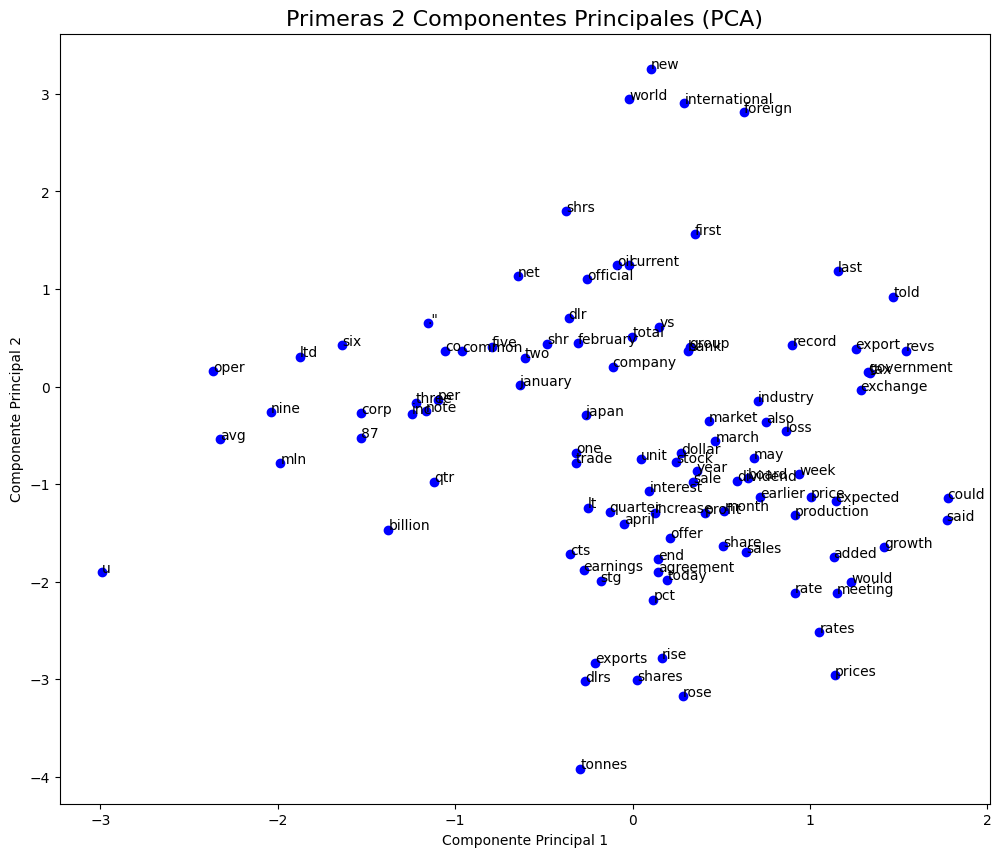

In [65]:
pca_2(embeddings,N,indices,index_to_word)

Vemos que a pesar de ser una aproximación con solo dos componentes de PCA se notan que semánticamente están cerca, como un conjunto en medio que trata temas de economía y precios. También hay otros ejemplos de palabras similares cuyos embeddings están cercas. Y aunque aparezcan otras palabras que no parecerían estar tan cerca en general creo que el resultado es muy interesante y bien aproximado a pesar de solo estar usando las 2 primeras componentes principales.

In [67]:
def cosine_similarity(word1, word2):
  """
  Calculates the cosine similarity between two tensors.
  """
  # Get the word embeddings for the specified words
  if word1 in words_indexes and word2 in words_indexes:
    x = model.embeddings.weight.data[words_indexes[word1]]
    y = model.embeddings.weight.data[words_indexes[word2]]
    similarity = torch.nn.functional.cosine_similarity(x, y, dim=0)
    print(f"Cosine Similarity between '{word1}' and '{word2}': {similarity}")
  else:
      print("One or both of the words are not in the vocabulary.")

In [68]:
Word1 = "good" #Replace with your first word
Word2 = "bad" #Replace with your second word
cosine_similarity(Word1, Word2)

Cosine Similarity between 'good' and 'bad': 0.02862251177430153


In [69]:
Word1 = "sun" #Replace with your first word
Word2 = "moon" #Replace with your second word
cosine_similarity(Word1, Word2)

One or both of the words are not in the vocabulary.


In [70]:
Word1 = "sun" #Replace with your first word
Word2 = "light" #Replace with your second word
cosine_similarity(Word1, Word2)

Cosine Similarity between 'sun' and 'light': 0.042934224009513855


In [71]:
Word1 = "women" #Replace with your first word
Word2 = "female" #Replace with your second word
cosine_similarity(Word1, Word2)

Cosine Similarity between 'women' and 'female': 0.022873565554618835


In [72]:
Word1 = "january" #Replace with your first word
Word2 = "month" #Replace with your second word
cosine_similarity(Word1, Word2)

Cosine Similarity between 'january' and 'month': 0.15822744369506836


In [73]:
def word_analogy(word1, word2, word3):
  """
  Calculates the analogy word4 given word1 is to word2 as word4 is to word3.
  """
  if word1 in words_indexes and word2 in words_indexes and word3 in words_indexes:
    # Get the word embeddings
    e1 = model.embeddings.weight.data[words_indexes[word1]]
    e2 = model.embeddings.weight.data[words_indexes[word2]]
    e3 = model.embeddings.weight.data[words_indexes[word3]]

    # Calculate the analogy vector
    analogy_vector = e2 - e1 + e3

    # Find the word with the embedding closest to the analogy vector
    similarities = torch.nn.functional.cosine_similarity(analogy_vector, model.embeddings.weight.data, dim=1)
    _, closest_word_index = torch.max(similarities, dim=0)
    word4 = index_to_word[closest_word_index.item()]

    print(f"'{word1}' is to '{word2}' as '{word3}' is to '{word4}'")
    return None
  else:
    print("One or more of the words are not in the vocabulary.")
    return None

word_analogy("london", "england", "mexico")

'london' is to 'england' as 'mexico' is to 'england'


In [74]:
ter=word_analogy("london", "england", "japan")


'london' is to 'england' as 'japan' is to 'japan'


### Parece que en el espacio completo de $200$ dimensiones en las cuales está entrenado el modelo, no se guardan muy bien las relaciones semánticas. Y creo que por lo mismo tampoco, como se ve en los ejemplos, las de analogías.


## **Reflexión Final**

### Aunque el modelo es muy complejo ya que fue entrenado con trigramas, no representa muy bien ciertas relaciones como son semánticas entre otras. También por ejemplo faltaba más vocabulario ya que no estaba la palabra woman por ejemplo.

### No obstante, creo que este modelo ya empieza a capturar ciertas relaciones como se ve en la gráfica de componente principales.


